In [1]:
from SimPEG import *

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 9 days


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
cs = 0.5
mesh = Mesh.TensorMesh([np.ones(100)*cs, np.ones(50)*cs], "CN")
x = mesh.vectorCCx

In [4]:
actind = mesh.gridCC[:,1] < -1.
meshact = Mesh.TensorMesh([mesh.hx, mesh.hy[:-2]], x0=mesh.x0)
actmap = Maps.ActiveCells(mesh, actind, 1e-2)

In [5]:
circmap = Maps.CircleMap(meshact)
circmap.slope = 1e5

In [6]:
mapping = actmap*circmap

In [7]:
# mapping = Maps.CircleMap(mesh)
mtrue = np.r_[np.log(1e0), np.log(1e-3), 0., -3., 2.]
m0 = np.r_[np.log(1e-3), np.log(1e-3), -3, -5., 1]

In [8]:
import simpegDCIP as DC

In [9]:
xr = np.linspace(-15, 15, 20)
xz_A = Utils.ndgrid(xr, np.r_[-0.25])
xz_B = Utils.ndgrid(np.ones_like(xr)*19, np.r_[-0.25])
xz_M = Utils.ndgrid(xr, np.r_[-0.25])
xz_N = Utils.ndgrid(np.ones_like(xr)*-19, np.r_[-0.25])

In [10]:
ntx = xz_A.shape[0]
txList = []
for i in range(ntx):
    offset = abs(xz_A[i,0]-xz_M[:,0])
    actrx = offset > 5.
    rx = DC.RxDipole(xz_M[actrx,:], xz_N[actrx,:])
    src = DC.SrcDipole([rx], xz_A[i,:], xz_B[i,:])
    txList.append(src)

In [11]:
survey = DC.SurveyDC(txList)
problem = DC.ProblemDC_CC(mesh, mapping = mapping)
problem.pair(survey)

In [12]:
from pymatsolver import MumpsSolver
problem.Solver = MumpsSolver

In [13]:
dini = survey.dpred(m0)
dtrue  = survey.dpred(mtrue)

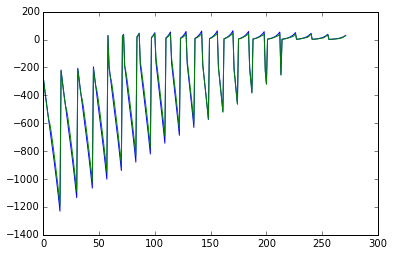

In [14]:
plot(dini)
plot(dtrue)
figsize(12, 5)

(array([  1.,   2.,   5.,   4.,  10.,  11.,  13.,  20.,  17.,  20.,  23.,
         10.,   0.,   0.,   4.,  17.,  29.,  36.,  32.,  18.]),
 array([-0.21911748, -0.05445749,  0.1102025 ,  0.27486249,  0.43952249,
         0.60418248,  0.76884247,  0.93350246,  1.09816245,  1.26282245,
         1.42748244,  1.59214243,  1.75680242,  1.92146242,  2.08612241,
         2.2507824 ,  2.41544239,  2.58010239,  2.74476238,  2.90942237,
         3.07408236]),
 <a list of 20 Patch objects>)

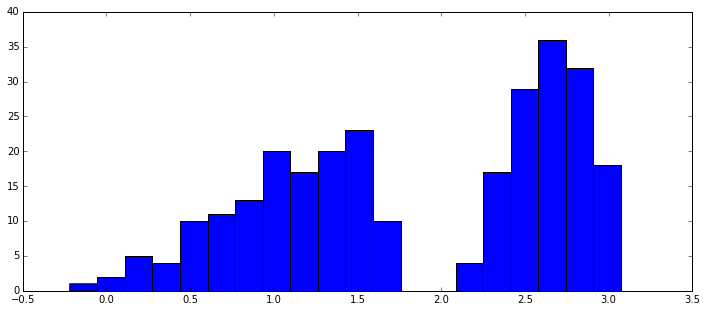

In [15]:
hist(np.log10(abs(dtrue)), bins = 20)

In [16]:
m1D = Mesh.TensorMesh([5])

<matplotlib.colorbar.Colorbar instance at 0x1110676c8>

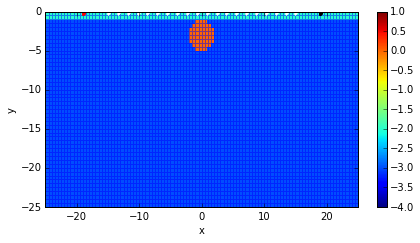

In [17]:
figsize(14*0.5,7*0.5)
circmodelest = mapping*mtrue
dat = mesh.plotImage(np.log10(circmodelest), clim=(-4, 1), grid=True, gridOpts={'alpha':0.5})
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'k.')
plot(xz_N[:,0], xz_N[:,1], 'r.')
# plot(temp.rxList[0].locs[0][:,0], temp.rxList[0].locs[0][:,1], 'bo')
plt.colorbar(dat[0])

In [18]:
survey.dobs = dtrue
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.01*abs(dtrue)+1.)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=30,tolX=1e-20, maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis, savemodel])
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.SaveModelEveryIteration will save your models as: '###-InversionModel-2015-09-15-13-32.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  4.69e+03  0.00e+00  4.69e+03    3.97e+04      0              
   1  0.00e+00  2.80e+03  4.41e-03  2.80e+03    1.09e+03      0              
   2  0.00e+00  2.59e+03  3.14e+01  2.59e+03    1.43e+04      1              
   3  0.00e+00  1.31e+03  4.23e+01  1.31e+03    1.48e+04      3              
   4  0.00e+00  1.22e+03  5.74e+01  1.22e+03    1.49e+04      4              
   5  0.00e+00  8.55e+02  3.58e+01  8.55e+02    2.20e+04      0              
   6  0.00e+00  6.43e+02  5.20e+01  6.43e+02    1.71e+04      3 

In [19]:
XC = opt.recall('xc')

In [20]:
from ipywidgets import interact, IntSlider

In [21]:
def viewinv(iteration):
#     iteration = 15
    figsize(10,6)
    ax1 = plt.subplot(211)
    circmodelest = mapping*mtrue
    if iteration > opt.iter-1:
        circmodeltrue = mapping*mopt
    else:
        circmodeltrue = mapping*XC[iteration]
    mesh.plotImage(np.log10(circmodelest), ax=ax1, clim=(-3, 0), grid=True, gridOpts={'alpha':0.5})
    ax2 = plt.subplot(212)
    mesh.plotImage(np.log10(circmodeltrue), ax=ax2, clim=(-3, 0), grid=True, gridOpts={'alpha':0.5})
    plt.show()
    return True

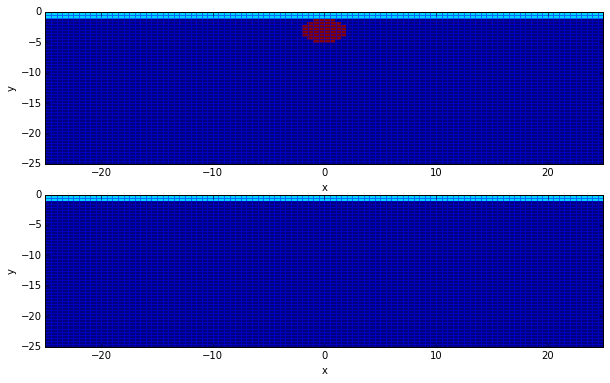

True

In [22]:
interact(viewinv, iteration=IntSlider(min=0, max=opt.iter, step = 1, value=0))

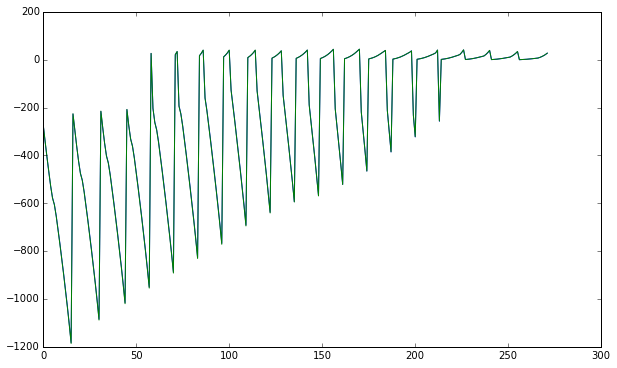

In [23]:
plot(invProb.dpred)
plot(dtrue)